In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

<Axes: >

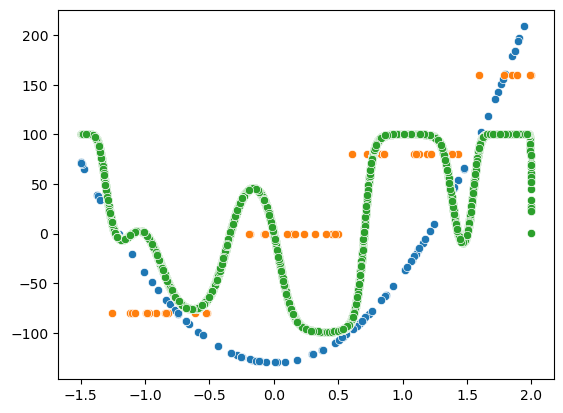

In [2]:
square_simple_train = pd.read_csv('../data/regression/square-simple-training.csv')[['x', 'y']]
steps_small_train = pd.read_csv('../data/regression/steps-small-training.csv')[['x', 'y']]
multimodal_large_train = pd.read_csv('../data/regression/multimodal-large-training.csv')[['x', 'y']]

square_simple_test = pd.read_csv('../data/regression/square-simple-test.csv')[['x', 'y']]
steps_small_test = pd.read_csv('../data/regression/steps-small-test.csv')[['x', 'y']]
multimodal_large_test = pd.read_csv('../data/regression/multimodal-large-test.csv')[['x', 'y']]

square_simple_train_X = np.array(square_simple_train['x'])
square_simple_train_Y = np.array(square_simple_train['y'])

square_simple_test_X = np.array(square_simple_test['x'])
square_simple_test_Y = np.array(square_simple_test['y'])

steps_small_train_X = np.array(steps_small_train['x'])
steps_small_train_Y = np.array(steps_small_train['y'])

steps_small_test_X = np.array(steps_small_test['x'])
steps_small_test_Y = np.array(steps_small_test['y'])

multimodal_large_train_X = np.array(multimodal_large_train['x'])
multimodal_large_train_Y = np.array(multimodal_large_train['y'])

multimodal_large_test_X = np.array(multimodal_large_test['x'])
multimodal_large_test_Y = np.array(multimodal_large_test['y'])

sns.scatterplot(x=square_simple_train_X, y=square_simple_train_Y)
sns.scatterplot(x=steps_small_train_X, y=steps_small_train_Y)
sns.scatterplot(x=multimodal_large_train_X, y=multimodal_large_train_Y)

In [3]:
def sigmoid(x):
	return 1/(1+np.e**(-x))

def sigmoid_derivative(x):
	return sigmoid(x) * (1 - sigmoid(x))

def linear(x):
	return x

def linear_derivative(x):
	return 1

class network:
	def __init__(self, architecture, activation_functions, activation_derivatives, initiation_method):
		self.architecture = architecture
		self.activation_functions = activation_functions
		self.activation_derivatives = activation_derivatives
		self.weights_biases_initiation(initiation_method)
		self.mse_record = []

	def set_state(self, architecture, biases, weights, activation_functions):
		self.architecture = architecture
		self.biases = biases
		self.weights = weights
		self.activation_functions = activation_functions

	def weights_biases_initiation(self, initiation_method):
		self.weights = [None]
		self.biases = [None]

		if initiation_method not in ['he', 'xavier', 'uniform']:
			print('Initiation method incorrect!')
			return 

		for i in range(len(self.architecture) - 1):
			input_dim = self.architecture[i]
			output_dim = self.architecture[i + 1]
			
			if initiation_method == 'he':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
			elif initiation_method == 'xavier':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(1 / input_dim)
			elif initiation_method == 'uniform':
				weight_matrix = np.random.uniform(0, 1, (input_dim, output_dim))

			bias_vector = np.zeros((1, output_dim))
			
			self.weights.append(weight_matrix)
			self.biases.append(bias_vector)

	def forward(self, X):
		# as a convention, for convinience, zeroth index of activations is raw input, i add None to preactivations for uniform indexing
		self.activations = [X]
		self.preactivations = [None]

		for i in range(0, len(self.architecture)-1):
			z = np.dot(self.activations[i], self.weights[i+1]) + self.biases[i+1]
			self.preactivations.append(z)
			
			a = self.activation_functions[i+1](z)
			self.activations.append(a)
	
	def check_MSE(self, x, y):
		self.forward(x)
		prediction = self.destandardize_data(self.activations[-1], 'y')
		correct = self.destandardize_data(y, 'y')
		return np.mean((correct - prediction) ** 2)
	
	def visualize_network(self):
		G = nx.DiGraph()
		pos = {}
		edge_colors = []
		edge_widths = []
		
		for layer_idx, num_nodes in enumerate(self.architecture):
			for node_idx in range(num_nodes):
				node_name = f"L{layer_idx}_N{node_idx}"
				pos[node_name] = (layer_idx, -node_idx)  
				G.add_node(node_name)
				
				if layer_idx > 0: 
					for prev_idx in range(self.architecture[layer_idx - 1]):
						prev_name = f"L{layer_idx-1}_N{prev_idx}"
						weight = self.weights[layer_idx][prev_idx][node_idx]

						if weight != 0:
							G.add_edge(prev_name, node_name)
							edge_colors.append('red' if weight < 0 else 'green')
							edge_widths.append(np.log(abs(weight)))
		
		plt.figure(figsize=(10, 5))
		nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", edge_color=edge_colors, width=edge_widths)
		plt.show()

	def backward(self, Y, step):
		self.error = [None] * (len(self.weights))
		self.weights_gradient = [None] * (len(self.weights))
		self.biases_gradient = [None] * (len(self.weights))

		self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		for i in reversed(range(1, len(self.error) - 1)):
			self.error[i] = np.dot(self.error[i+1], self.weights[i+1].T) * self.activation_derivatives[i](self.preactivations[i])
		
		for i in range(1, len(self.error)):
			self.weights_gradient[i] = -step * np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			self.biases_gradient[i] = (-step * np.mean(self.error[i], axis=0)).reshape(1, -1)

	def prepeare_batches(self, data, batch_size=None):
		n = len(data)
		if batch_size == None:
			batch_number = 1
		else:
			batch_number = int(np.ceil(n / batch_size))

		data_shuffled = np.random.permutation(data)
		x = data_shuffled[:,0].reshape(n,1)
		y = data_shuffled[:,1].reshape(n,1)

		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')
		
		x = np.array_split(x, batch_number)
		y = np.array_split(y, batch_number)

		return x, y, batch_number
	
	def learn_old(self, x, y, step, iterations):
		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')

		for e in range(iterations):
			self.forward(x)
			self.backward(y, step)
			
			for i in range(1, len(self.architecture)):
					self.weights[i] += self.weights_gradient[i]
					self.biases[i] += self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(x, y))

	def learn(self, data, epochs_number, step, batch_size=None):
		for e in range(epochs_number):
			x, y, batch_number = self.prepeare_batches(data, batch_size)

			for b in range(batch_number):
				self.forward(x[b])
				self.backward(y[b], step)

				for i in range(1, len(self.architecture)):
					self.weights[i] += self.weights_gradient[i]
					self.biases[i] += self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(np.vstack(x), np.vstack(y)))

	def standardize_data(self, data, type):
		mean = np.mean(data, axis=0)
		std = np.std(data, axis=0)
		data_new = (data - mean) / std

		if type == 'x':
			self.standardize_params_x = (mean, std)
		if type == 'y':
			self.standardize_params_y = (mean, std)

		return data_new

	def destandardize_data(self, data, type):
		if type == 'x':
			return data * self.standardize_params_x[1] + self.standardize_params_x[0]
		if type == 'y':
			return data * self.standardize_params_y[1] + self.standardize_params_y[0]
		

In [428]:
network_ss_5_5 = network(np.array([1, 5, 1]), [None, sigmoid, linear], [None, sigmoid_derivative, linear_derivative], 'xavier')
network_ss_5_5.learn(square_simple_train, 5000, 0.075, 5)

network_ss_5_15 = network(np.array([1, 5, 1]), [None, sigmoid, linear], [None, sigmoid_derivative, linear_derivative], 'xavier')
network_ss_5_15.learn(square_simple_train, 5000, 0.075, 15)

network_ss_5_25 = network(np.array([1, 5, 1]), [None, sigmoid, linear], [None, sigmoid_derivative, linear_derivative], 'xavier')
network_ss_5_25.learn(square_simple_train, 5000, 0.075, 25)

network_ss_5_35 = network(np.array([1, 5, 1]), [None, sigmoid, linear], [None, sigmoid_derivative, linear_derivative], 'xavier')
network_ss_5_35.learn(square_simple_train, 5000, 0.075, 35)

Final mse batch 5:  2.8908642247023346
Final mse batch 15:  2.1232902768139468
Final mse batch 25:  3.1500110307728395
Final mse batch 35:  10.211137271766713


<Axes: >

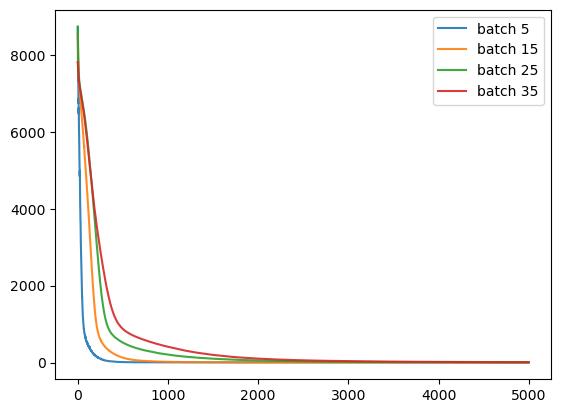

In [498]:
print('Final mse batch 5: ', network_ss_5_5.mse_record[-1])
print('Final mse batch 15: ', network_ss_5_15.mse_record[-1])
print('Final mse batch 25: ', network_ss_5_25.mse_record[-1])
print('Final mse batch 35: ', network_ss_5_35.mse_record[-1])

sns.lineplot(network_ss_5_5.mse_record, alpha=0.9, label='batch 5')
sns.lineplot(network_ss_5_15.mse_record, alpha=0.9, label='batch 15')
sns.lineplot(network_ss_5_25.mse_record, alpha=0.9, label='batch 25')
sns.lineplot(network_ss_5_35.mse_record, alpha=0.9, label='batch 35')

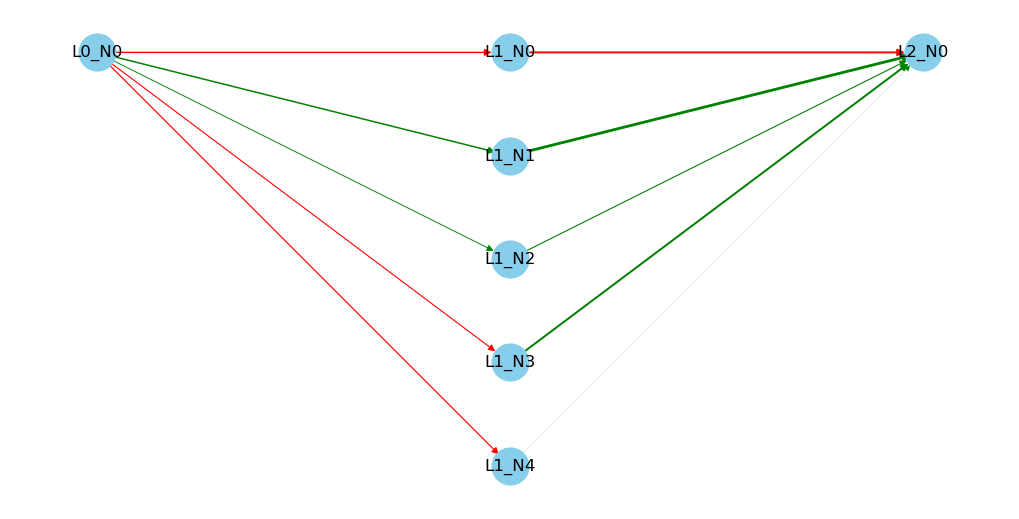

In [499]:
network_ss_5_15.visualize_network()

test mse: 2.9272991676861557


<Axes: >

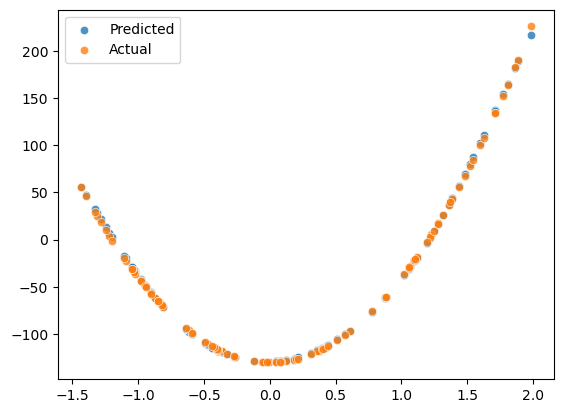

In [518]:
x = square_simple_test_X.reshape(100,1)
y = square_simple_test_Y.reshape(100,1)
x_std = (x - network_ss_5_15.standardize_params_x[0]) / network_ss_5_15.standardize_params_x[1]

network_ss_5_15.forward(x_std)
y_pred_std = network_ss_5_15.activations[-1]
y_pred = network_ss_5_15.destandardize_data(y_pred_std, 'y')

print('test mse:', np.mean((y - y_pred) ** 2))

sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

In [24]:
network_step_55_5 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_step_55_5.learn(steps_small_train, 80000, 0.1, 5)

network_step_55_15 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_step_55_15.learn(steps_small_train, 80000, 0.1, 15)

network_step_55_25 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_step_55_25.learn(steps_small_train, 80000, 0.1, 25)

network_step_55_35 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_step_55_35.learn(steps_small_train, 80000, 0.1, 35)

Final mse batch 5:  2.467504897901744
Final mse batch 15:  56.58288220929099
Final mse batch 25:  360.50072291650037
Final mse batch 35:  359.46641501025675


<Axes: >

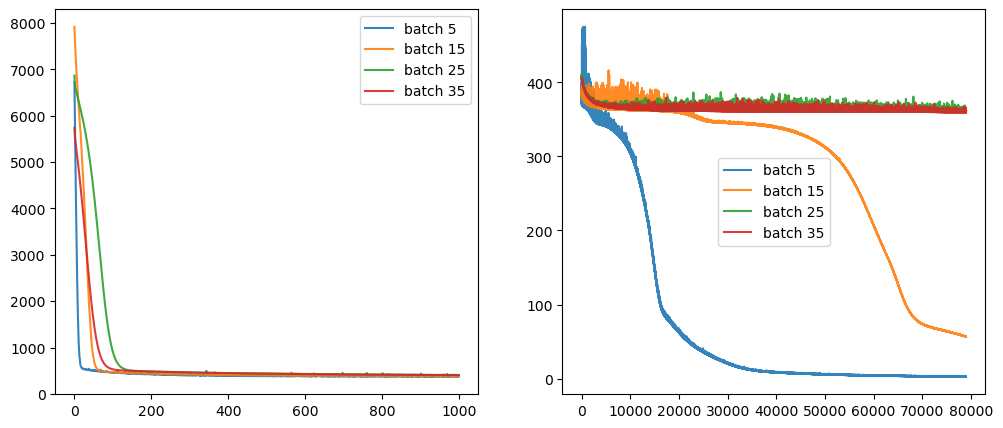

In [29]:
print('Final mse batch 5: ', network_step_55_5.mse_record[-1])
print('Final mse batch 15: ', network_step_55_15.mse_record[-1])
print('Final mse batch 25: ', network_step_55_25.mse_record[-1])
print('Final mse batch 35: ', network_step_55_35.mse_record[-1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(network_step_55_5.mse_record[:1000], alpha=0.9, label='batch 5', ax=axes[0])
sns.lineplot(network_step_55_15.mse_record[:1000], alpha=0.9, label='batch 15', ax=axes[0])
sns.lineplot(network_step_55_25.mse_record[:1000], alpha=0.9, label='batch 25', ax=axes[0])
sns.lineplot(network_step_55_35.mse_record[:1000], alpha=0.9, label='batch 35', ax=axes[0])

sns.lineplot(network_step_55_5.mse_record[1000:], alpha=0.9, label='batch 5', ax=axes[1])
sns.lineplot(network_step_55_15.mse_record[1000:], alpha=0.9, label='batch 15', ax=axes[1])
sns.lineplot(network_step_55_25.mse_record[1000:], alpha=0.9, label='batch 25', ax=axes[1])
sns.lineplot(network_step_55_35.mse_record[1000:], alpha=0.9, label='batch 35', ax=axes[1])

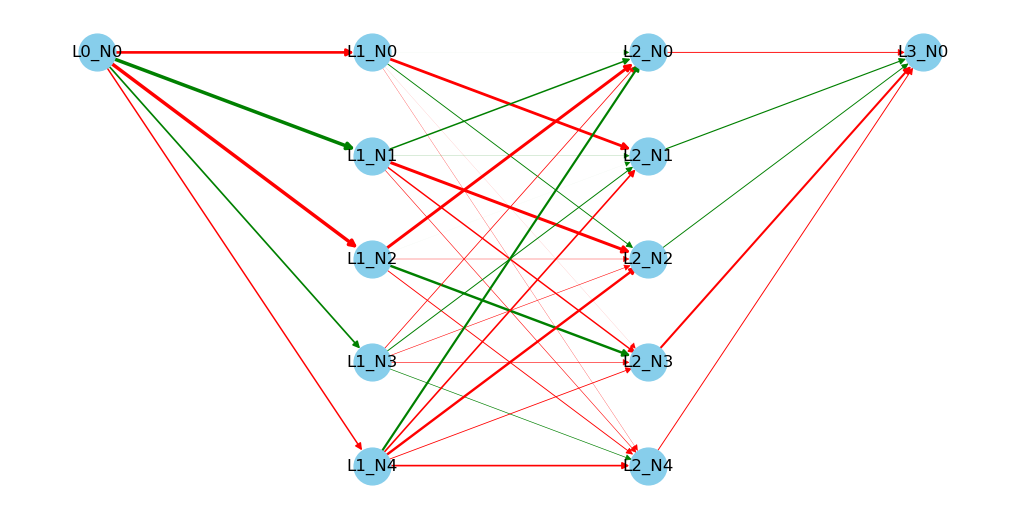

In [30]:
network_step_55_5.visualize_network()

<Axes: >

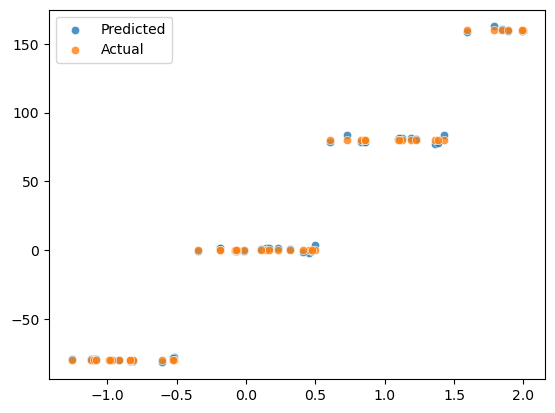

In [27]:
x = steps_small_train_X.reshape(50,1)
y = steps_small_train_Y.reshape(50,1)
x_std = (x - network_step_55_5.standardize_params_x[0]) / network_step_55_5.standardize_params_x[1]

network_step_55_5.forward(x_std)
y_pred_std = network_step_55_5.activations[-1]
y_pred = network_step_55_5.destandardize_data(y_pred_std, 'y')


sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

test mse: 130.6244989452042


<Axes: >

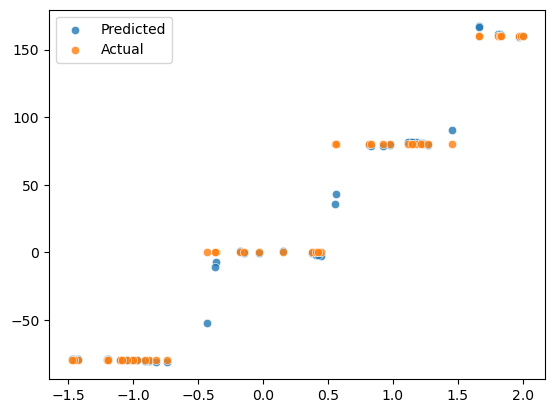

In [28]:
x = steps_small_test_X.reshape(50,1)
y = steps_small_test_Y.reshape(50,1)
x_std = (x - network_step_55_5.standardize_params_x[0]) / network_step_55_5.standardize_params_x[1]

network_step_55_5.forward(x_std)
y_pred_std = network_step_55_5.activations[-1]
y_pred = network_step_55_5.destandardize_data(y_pred_std, 'y')

print('test mse:', np.mean((y - y_pred) ** 2))

sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

In [32]:
network_multi_55_500 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multi_55_500.learn(multimodal_large_train, 20000, 0.5, 500)

network_multi_55_250 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multi_55_250.learn(multimodal_large_train, 20000, 0.5, 250)

network_multi_55_250_1 = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multi_55_250_1.learn(multimodal_large_train, 20000, 1, 250)

network_multi_1010_500 = network(np.array([1, 10, 10, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multi_1010_500.learn(multimodal_large_train, 20000, 0.5, 500)

network_multi_1010_250 = network(np.array([1, 10, 10, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multi_1010_250.learn(multimodal_large_train, 20000, 0.5, 250)

network_multi_1010_250_1 = network(np.array([1, 10, 10, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multi_1010_250_1.learn(multimodal_large_train, 20000, 1, 250)

Final mse network_multi_55_500:  320.59480776389717
Final mse network_multi_55_250:  17.07300440058157
Final mse network_multi_55_250_1:  296.9951657072367
Final mse network_multi_1010_500:  6.845182366210513
Final mse network_multi_1010_250:  7.106422930888839
Final mse network_multi_1010_250_1:  6.13554067874538


<Axes: >

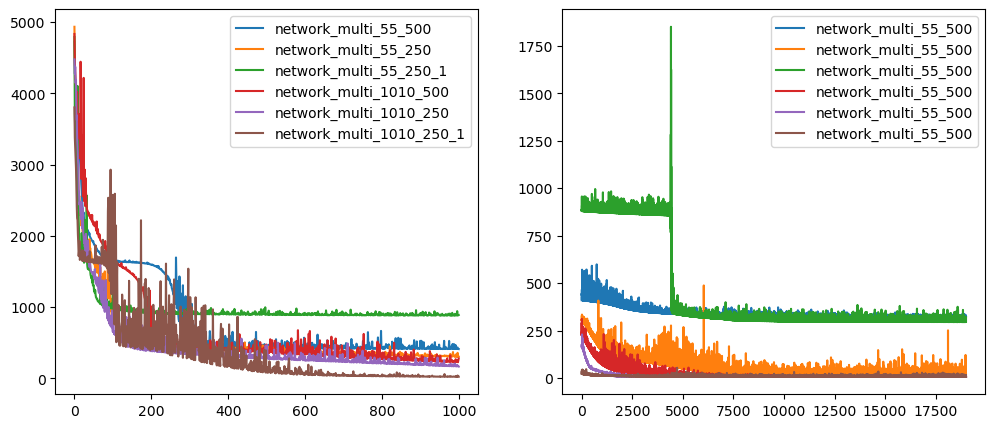

In [33]:
print('Final mse network_multi_55_500: ', network_multi_55_500.mse_record[-1])
print('Final mse network_multi_55_250: ', network_multi_55_250.mse_record[-1])
print('Final mse network_multi_55_250_1: ', network_multi_55_250_1.mse_record[-1])
print('Final mse network_multi_1010_500: ', network_multi_1010_500.mse_record[-1])
print('Final mse network_multi_1010_250: ', network_multi_1010_250.mse_record[-1])
print('Final mse network_multi_1010_250_1: ', network_multi_1010_250_1.mse_record[-1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(network_multi_55_500.mse_record[:1000], label='network_multi_55_500', ax=axes[0])
sns.lineplot(network_multi_55_250.mse_record[:1000], label='network_multi_55_250', ax=axes[0])
sns.lineplot(network_multi_55_250_1.mse_record[:1000], label='network_multi_55_250_1', ax=axes[0])
sns.lineplot(network_multi_1010_500.mse_record[:1000], label='network_multi_1010_500', ax=axes[0])
sns.lineplot(network_multi_1010_250.mse_record[:1000], label='network_multi_1010_250', ax=axes[0])
sns.lineplot(network_multi_1010_250_1.mse_record[:1000], label='network_multi_1010_250_1', ax=axes[0])

sns.lineplot(network_multi_55_500.mse_record[1000:], label='network_multi_55_500', ax=axes[1])
sns.lineplot(network_multi_55_250.mse_record[1000:], label='network_multi_55_500', ax=axes[1])
sns.lineplot(network_multi_55_250_1.mse_record[1000:], label='network_multi_55_500', ax=axes[1])
sns.lineplot(network_multi_1010_500.mse_record[1000:], label='network_multi_55_500', ax=axes[1])
sns.lineplot(network_multi_1010_250.mse_record[1000:], label='network_multi_55_500', ax=axes[1])
sns.lineplot(network_multi_1010_250_1.mse_record[1000:], label='network_multi_55_500', ax=axes[1])

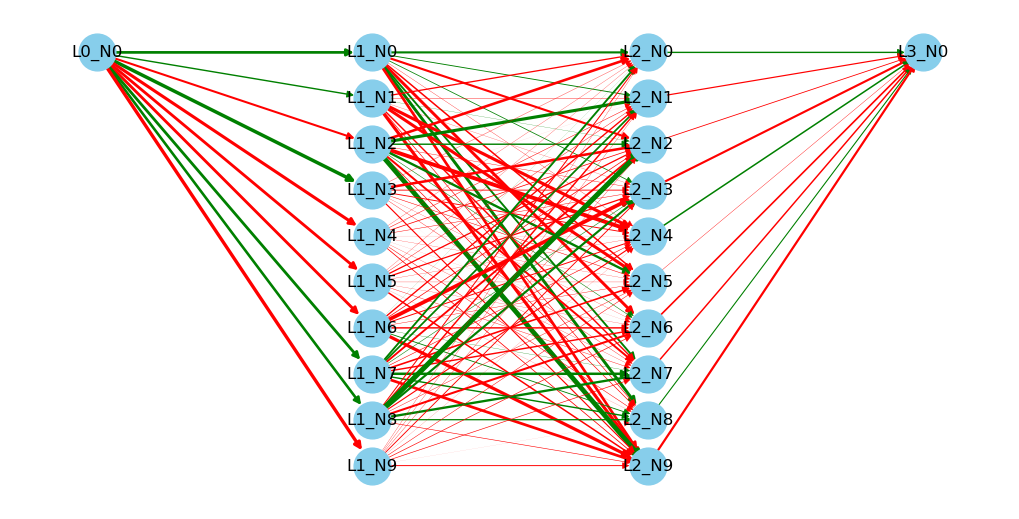

In [34]:
network_multi_1010_250_1.visualize_network()

<Axes: >

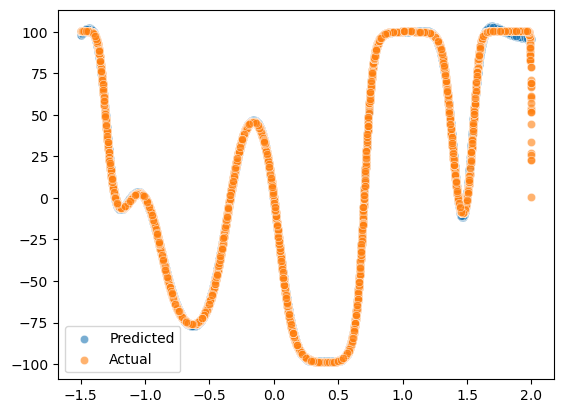

In [476]:
plot_network = network_multi_1010_500

x = multimodal_large_train_X.reshape(10000 ,1)
y = multimodal_large_train_Y.reshape(10000 ,1)
x_std = (x - plot_network.standardize_params_x[0]) / plot_network.standardize_params_x[1]

plot_network.forward(x_std)
y_pred_std = plot_network.activations[-1]
y_pred = plot_network.destandardize_data(y_pred_std, 'y')

sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.6, label='Predicted')
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.6, label='Actual')

test mse: 2.5781319003016296


<Axes: >

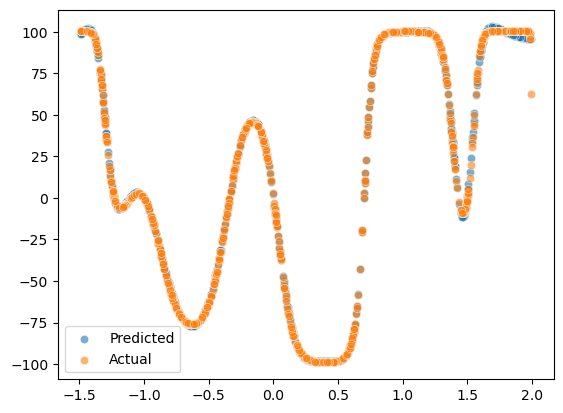

In [516]:
plot_network = network_multi_1010_500

x = multimodal_large_test_X.reshape(1000 ,1)
y = multimodal_large_test_Y.reshape(1000 ,1)
x_std = (x - plot_network.standardize_params_x[0]) / plot_network.standardize_params_x[1]

plot_network.forward(x_std)
y_pred_std = plot_network.activations[-1]
y_pred = plot_network.destandardize_data(y_pred_std, 'y')

print('test mse:', np.mean((y - y_pred) ** 2))

sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.6, label='Predicted')
sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.6, label='Actual')

Całościowo widać, że zmniejszanie wielkość batchy wpływa korzystnie na tempo uczenia, kosztem długości obliczeń.